In [3]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# implement data collection procedure on the RTBGym environment

# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from basicgym import BasicEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [7]:
# standardized environment for discrete action
env = gym.make("BasicEnv-continuous-v0")
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [8]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    # n_steps=1000,
    # n_steps_per_epoch=10,
    # update_start_step=10,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)
# save model
sac.save_model("d3rlpy_logs/sac.pt")
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

2023-04-01 17:18.13 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230401171813
2023-04-01 17:18.13 [debug    ] Fitting action scaler...       action_scler=min_max
2023-04-01 17:18.13 [debug    ] Building model...
2023-04-01 17:18.13 [debug    ] Model has been built.
2023-04-01 17:18.13 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230401171813/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': 

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/100000 [00:00<?, ?it/s]

2023-04-01 17:18.13 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230401171813/model_1000.pt
2023-04-01 17:18.13 [info     ] SAC_online_20230401171813: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0003254365921020508, 'time_environment_step': 4.0656805038452145e-05, 'time_step': 0.00037992095947265623, 'rollout_return': 0.08932265374065683, 'evaluation': -1.1987574441669455} step=1000
2023-04-01 17:18.17 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230401171813/model_2000.pt
2023-04-01 17:18.17 [info     ] SAC_online_20230401171813: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0003221769332885742, 'time_environment_step': 7.005953788757324e-05, 'time_sample_batch': 0.0001411590576171875, 'time_algorithm_update': 0.0035253260135650636, 'temp_loss': 4.34237682890892, 'temp': 0.8688093042373657, 'critic_loss': 4.282832696080208, 'actor_loss': -4.036695408940315, 'time_step': 0.004087400913238525, 'rollout_return': 0.8257275482

In [9]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL

In [10]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
# basic estimators
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
# self normalized estimators
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
# marginal estimators
from ofrl.ope import ContinuousStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import ContinuousStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import ContinuousStateMarginalImportanceSampling as SMIS
from ofrl.ope import ContinuousStateMarginalDoublyRobust as SMDR
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import ContinuousStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import ContinuousStateMarginalSelfNormalizedDoublyRobust as SMSNDR
# double reinforcement learning estimators
from ofrl.ope import ContinuousDoubleReinforcementLearning as DRL

In [11]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [12]:
# n_trajectories_list = [100, 200, 400]
# n_trajectories_list = [100, 200, 400, 800, 1600, 6400]
n_trajectories_list = [100, 200, 400, 800, 1600]
# random_state_list = [10, 20, 30]
random_state_list = [10, 20, 30, 40, 50]

bias_df_list = []
variance_df_list = []
mse_df_list = []

In [14]:

for n_trajectories in n_trajectories_list:
    cql_data = DataFrame()
    sac_data = DataFrame()
    for random_state in random_state_list:
    
        behavior_policy = TruncatedGaussianHead(
            sac, 
            minimum=env.action_space.low,
            maximum=env.action_space.high,
            sigma=np.array([1.0]),
            name="sac_sigma_1.0",
            random_state=random_state,
        )

        # initialize dataset class
        dataset = SyntheticDataset(
            env=env,
            max_episode_steps=env.step_per_episode,
        )

        # collect logged data by a behavior policy
        # skip if there is a preserved logged dataset
        train_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=False,
            random_state=random_state,
        )
        test_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=False,
            random_state=random_state + 1,
        )

        # transform offline dataset for d3rlpy
        offlinerl_dataset = MDPDataset(
            observations=train_logged_dataset["state"],
            actions=train_logged_dataset["action"],
            rewards=train_logged_dataset["reward"],
            terminals=train_logged_dataset["done"],
            episode_terminals=train_logged_dataset["done"],
            discrete_action=False,
        )
        train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

        # # Use Conservative Q-Learning policy
        # cql = CQL(
        #     actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
        #     critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
        #     q_func_factory=MeanQFunctionFactory(),
        #     use_gpu=torch.cuda.is_available(),
        #     action_scaler=MinMaxActionScaler(
        #         minimum=env_.action_space.low,  # minimum value that policy can take
        #         maximum=env_.action_space.high,  # maximum value that policy can take
        #     )
        # )

        # cql.fit(
        #     train_episodes,
        #     eval_episodes=test_episodes,
        #     n_steps=10000,
        #     # n_steps=10000,
        #     scorers={},
        # )

        # # # save model
        # # cql.save_model("d3rlpy_logs/cql_continuous.pt")

        # # # reload model
        # # cql.build_with_env(env)
        # # cql.load_model("d3rlpy_logs/cql_continuous.pt")

        # # define evaluation policies (should be deterministic policy)
        # cql_ = ContinuousEvalHead(
        #     base_policy=cql,
        #     name="cql",
        # )
        sac_ = ContinuousEvalHead(
            base_policy=sac, 
            name="sac", 
        )
        evaluation_policies = [sac_]
        # evaluation_policies = [cql_, sac_]
        
        # first, prepare OPE inputs
        prep = CreateOPEInput(
            env=env,
            model_args={
                "fqe": {
                    "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
                    "q_func_factory": MeanQFunctionFactory(),
                    "learning_rate": 1e-4,
                    "use_gpu": torch.cuda.is_available(),
                },
            },
            state_scaler=MinMaxScaler(
                minimum=test_logged_dataset["state"].min(axis=0),
                maximum=test_logged_dataset["state"].max(axis=0),
            ),
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            gamma=0.95,
            sigma=0.1,
            device="cuda:0" if torch.cuda.is_available() else "cpu",
        )

        # takes time
        input_dict = prep.obtain_whole_inputs(
            logged_dataset=test_logged_dataset,
            evaluation_policies=evaluation_policies,
            require_value_prediction=True,
            require_weight_prediction=True,
            n_trajectories_on_policy_evaluation=100,
            random_state=random_state,
        )

        ope = OPE(
            logged_dataset=test_logged_dataset,
            ope_estimators=all_estimators,
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            sigma=0.1,
        )

        policy_value_dict = ope.estimate_policy_value(
            input_dict=input_dict,
        )
        
        # tmp_cql = DataFrame(policy_value_dict)['cql']
        # cql_data = pd.concat([cql_data, tmp_cql], axis=1)
        tmp_sac = DataFrame(policy_value_dict)['sac']
        sac_data = pd.concat([sac_data, tmp_sac], axis=1)
        
        
    bias = abs(sac_data.mean(axis=1) - sac_data.mean(axis=1)['on_policy'])
    variance = sac_data.var(axis=1)
    mse = bias**2 + variance
    # bias = abs(cql_data.mean(axis=1) - cql_data.mean(axis=1)['on_policy'])
    # variance = cql_data.var(axis=1)

    bias_df = DataFrame(DataFrame(bias).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "bias"})
    bias_df["n_trajectories"] = n_trajectories
    bias_df_list.append(bias_df)
    
    variance_df = DataFrame(DataFrame(variance).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "variance"})
    variance_df["n_trajectories"] = n_trajectories
    variance_df_list.append(variance_df)

    mse_df = DataFrame(DataFrame(mse).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "mse"})
    mse_df["n_trajectories"] = n_trajectories
    mse_df_list.append(mse_df)



[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:30.00 [debug    ] RoundIterator is selected.
2023-04-01 17:30.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173000
2023-04-01 17:30.00 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:30.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:30.00 [debug    ] Building models...
2023-04-01 17:30.00 [debug    ] Models have been built.
2023-04-01 17:30.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173000/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-01 17:30.00 [info     ] FQE_20230401173000: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 8.83340835571289e-05, 'time_algorithm_update': 0.001439356803894043, 'loss': 0.12368170842528343, 'time_step': 0.0015662908554077148} step=10
2023-04-01 17:30.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173000/model_10.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:30.23 [debug    ] RoundIterator is selected.
2023-04-01 17:30.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173023
2023-04-01 17:30.23 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:30.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:30.23 [debug    ] Building models...
2023-04-01 17:30.23 [debug    ] Models have been built.
2023-04-01 17:30.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173023/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-01 17:30.23 [info     ] FQE_20230401173023: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00010366439819335938, 'time_algorithm_update': 0.0015702247619628906, 'loss': 0.14660930782556533, 'time_step': 0.001723480224609375} step=10
2023-04-01 17:30.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173023/model_10.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:30.46 [debug    ] RoundIterator is selected.
2023-04-01 17:30.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173046
2023-04-01 17:30.46 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:30.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:30.46 [debug    ] Building models...
2023-04-01 17:30.46 [debug    ] Models have been built.
2023-04-01 17:30.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173046/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-01 17:30.46 [info     ] FQE_20230401173046: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 8.614063262939453e-05, 'time_algorithm_update': 0.001975083351135254, 'loss': 0.12522384151816368, 'time_step': 0.0021044731140136717} step=10
2023-04-01 17:30.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173046/model_10.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:31.11 [debug    ] RoundIterator is selected.
2023-04-01 17:31.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173111
2023-04-01 17:31.11 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:31.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:31.11 [debug    ] Building models...
2023-04-01 17:31.11 [debug    ] Models have been built.
2023-04-01 17:31.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173111/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-01 17:31.11 [info     ] FQE_20230401173111: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 9.386539459228515e-05, 'time_algorithm_update': 0.00191953182220459, 'loss': 0.13512119576334952, 'time_step': 0.002065277099609375} step=10
2023-04-01 17:31.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173111/model_10.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:31.33 [debug    ] RoundIterator is selected.
2023-04-01 17:31.33 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173133
2023-04-01 17:31.33 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:31.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:31.33 [debug    ] Building models...
2023-04-01 17:31.33 [debug    ] Models have been built.
2023-04-01 17:31.33 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173133/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-01 17:31.33 [info     ] FQE_20230401173133: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 8.742809295654297e-05, 'time_algorithm_update': 0.001774168014526367, 'loss': 0.14478099644184111, 'time_step': 0.0019021749496459961} step=10
2023-04-01 17:31.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173133/model_10.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:31.56 [debug    ] RoundIterator is selected.
2023-04-01 17:31.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173156
2023-04-01 17:31.56 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:31.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:31.56 [debug    ] Building models...
2023-04-01 17:31.56 [debug    ] Models have been built.
2023-04-01 17:31.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173156/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-01 17:31.56 [info     ] FQE_20230401173156: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 8.790493011474609e-05, 'time_algorithm_update': 0.0014227032661437988, 'loss': 0.10944238938391208, 'time_step': 0.0015528559684753417} step=20
2023-04-01 17:31.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173156/model_20.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:32.19 [debug    ] RoundIterator is selected.
2023-04-01 17:32.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173219
2023-04-01 17:32.19 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:32.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:32.19 [debug    ] Building models...
2023-04-01 17:32.19 [debug    ] Models have been built.
2023-04-01 17:32.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173219/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-01 17:32.19 [info     ] FQE_20230401173219: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00010799169540405273, 'time_algorithm_update': 0.002133381366729736, 'loss': 0.14173550456762313, 'time_step': 0.0023314237594604494} step=20
2023-04-01 17:32.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173219/model_20.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:32.41 [debug    ] RoundIterator is selected.
2023-04-01 17:32.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173241
2023-04-01 17:32.41 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:32.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:32.41 [debug    ] Building models...
2023-04-01 17:32.41 [debug    ] Models have been built.
2023-04-01 17:32.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173241/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-01 17:32.42 [info     ] FQE_20230401173241: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 8.211135864257812e-05, 'time_algorithm_update': 0.0012774109840393067, 'loss': 0.12406322583556176, 'time_step': 0.0014014959335327149} step=20
2023-04-01 17:32.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173241/model_20.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:33.04 [debug    ] RoundIterator is selected.
2023-04-01 17:33.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173304
2023-04-01 17:33.04 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:33.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:33.04 [debug    ] Building models...
2023-04-01 17:33.04 [debug    ] Models have been built.
2023-04-01 17:33.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173304/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-01 17:33.04 [info     ] FQE_20230401173304: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00010210275650024414, 'time_algorithm_update': 0.001962006092071533, 'loss': 0.13645456433296205, 'time_step': 0.0021181344985961915} step=20
2023-04-01 17:33.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173304/model_20.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:33.28 [debug    ] RoundIterator is selected.
2023-04-01 17:33.28 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173328
2023-04-01 17:33.28 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:33.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:33.28 [debug    ] Building models...
2023-04-01 17:33.28 [debug    ] Models have been built.
2023-04-01 17:33.28 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173328/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-01 17:33.28 [info     ] FQE_20230401173328: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00012108087539672852, 'time_algorithm_update': 0.0016598463058471679, 'loss': 0.13992572464048864, 'time_step': 0.0018577814102172852} step=20
2023-04-01 17:33.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173328/model_20.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:33.54 [debug    ] RoundIterator is selected.
2023-04-01 17:33.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173354
2023-04-01 17:33.54 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:33.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:33.54 [debug    ] Building models...
2023-04-01 17:33.54 [debug    ] Models have been built.
2023-04-01 17:33.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173354/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-01 17:33.54 [info     ] FQE_20230401173354: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 8.412003517150879e-05, 'time_algorithm_update': 0.001217871904373169, 'loss': 0.11057512387633324, 'time_step': 0.0013463139533996583} step=40
2023-04-01 17:33.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173354/model_40.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:34.21 [debug    ] RoundIterator is selected.
2023-04-01 17:34.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173421
2023-04-01 17:34.21 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:34.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:34.21 [debug    ] Building models...
2023-04-01 17:34.21 [debug    ] Models have been built.
2023-04-01 17:34.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173421/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-01 17:34.21 [info     ] FQE_20230401173421: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 8.996725082397461e-05, 'time_algorithm_update': 0.0011522531509399413, 'loss': 0.13674493990838527, 'time_step': 0.0012892842292785644} step=40
2023-04-01 17:34.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173421/model_40.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:34.48 [debug    ] RoundIterator is selected.
2023-04-01 17:34.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173448
2023-04-01 17:34.48 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:34.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:34.48 [debug    ] Building models...
2023-04-01 17:34.48 [debug    ] Models have been built.
2023-04-01 17:34.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173448/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-01 17:34.48 [info     ] FQE_20230401173448: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 9.655356407165528e-05, 'time_algorithm_update': 0.0014300048351287842, 'loss': 0.11570490896701813, 'time_step': 0.0016001641750335693} step=40
2023-04-01 17:34.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173448/model_40.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:35.15 [debug    ] RoundIterator is selected.
2023-04-01 17:35.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173515
2023-04-01 17:35.15 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:35.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:35.15 [debug    ] Building models...
2023-04-01 17:35.15 [debug    ] Models have been built.
2023-04-01 17:35.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173515/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-01 17:35.15 [info     ] FQE_20230401173515: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 9.059906005859375e-05, 'time_algorithm_update': 0.001205575466156006, 'loss': 0.13545753341168165, 'time_step': 0.0013450682163238525} step=40
2023-04-01 17:35.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173515/model_40.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:35.42 [debug    ] RoundIterator is selected.
2023-04-01 17:35.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173542
2023-04-01 17:35.42 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:35.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:35.42 [debug    ] Building models...
2023-04-01 17:35.42 [debug    ] Models have been built.
2023-04-01 17:35.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173542/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-01 17:35.42 [info     ] FQE_20230401173542: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.00010943412780761719, 'time_algorithm_update': 0.00172957181930542, 'loss': 0.13772779274731875, 'time_step': 0.0018974781036376954} step=40
2023-04-01 17:35.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173542/model_40.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:36.16 [debug    ] RoundIterator is selected.
2023-04-01 17:36.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173616
2023-04-01 17:36.16 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:36.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:36.16 [debug    ] Building models...
2023-04-01 17:36.16 [debug    ] Models have been built.
2023-04-01 17:36.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173616/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-01 17:36.16 [info     ] FQE_20230401173616: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 9.292662143707275e-05, 'time_algorithm_update': 0.0010863810777664185, 'loss': 0.10080809583887458, 'time_step': 0.0012306392192840577} step=80
2023-04-01 17:36.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173616/model_80.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:36.51 [debug    ] RoundIterator is selected.
2023-04-01 17:36.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173651
2023-04-01 17:36.51 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:36.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:36.51 [debug    ] Building models...
2023-04-01 17:36.51 [debug    ] Models have been built.
2023-04-01 17:36.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173651/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-01 17:36.51 [info     ] FQE_20230401173651: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 9.185671806335449e-05, 'time_algorithm_update': 0.0011678457260131836, 'loss': 0.13292420748621225, 'time_step': 0.001308634877204895} step=80
2023-04-01 17:36.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173651/model_80.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:37.24 [debug    ] RoundIterator is selected.
2023-04-01 17:37.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173724
2023-04-01 17:37.24 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:37.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:37.24 [debug    ] Building models...
2023-04-01 17:37.24 [debug    ] Models have been built.
2023-04-01 17:37.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173724/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-01 17:37.25 [info     ] FQE_20230401173724: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 9.032487869262696e-05, 'time_algorithm_update': 0.0011028707027435302, 'loss': 0.1156519022770226, 'time_step': 0.0012308776378631592} step=80
2023-04-01 17:37.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173724/model_80.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:37.58 [debug    ] RoundIterator is selected.
2023-04-01 17:37.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173758
2023-04-01 17:37.58 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:37.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:37.58 [debug    ] Building models...
2023-04-01 17:37.58 [debug    ] Models have been built.
2023-04-01 17:37.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173758/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-01 17:37.58 [info     ] FQE_20230401173758: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 9.796619415283203e-05, 'time_algorithm_update': 0.0010885447263717651, 'loss': 0.1267209985293448, 'time_step': 0.0012353956699371338} step=80
2023-04-01 17:37.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173758/model_80.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:38.32 [debug    ] RoundIterator is selected.
2023-04-01 17:38.32 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173832
2023-04-01 17:38.32 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:38.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:38.32 [debug    ] Building models...
2023-04-01 17:38.32 [debug    ] Models have been built.
2023-04-01 17:38.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173832/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-01 17:38.32 [info     ] FQE_20230401173832: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 9.043514728546143e-05, 'time_algorithm_update': 0.001114112138748169, 'loss': 0.13062791228294374, 'time_step': 0.0012523055076599122} step=80
2023-04-01 17:38.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173832/model_80.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:39.19 [debug    ] RoundIterator is selected.
2023-04-01 17:39.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230401173919
2023-04-01 17:39.19 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:39.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:39.19 [debug    ] Building models...
2023-04-01 17:39.19 [debug    ] Models have been built.
2023-04-01 17:39.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401173919/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-01 17:39.19 [info     ] FQE_20230401173919: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 9.200721979141235e-05, 'time_algorithm_update': 0.001050455868244171, 'loss': 0.09841471966356038, 'time_step': 0.001186835765838623} step=160
2023-04-01 17:39.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401173919/model_160.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:40.05 [debug    ] RoundIterator is selected.
2023-04-01 17:40.05 [info     ] Directory is created at d3rlpy_logs/FQE_20230401174005
2023-04-01 17:40.05 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:40.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:40.05 [debug    ] Building models...
2023-04-01 17:40.05 [debug    ] Models have been built.
2023-04-01 17:40.05 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401174005/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-01 17:40.06 [info     ] FQE_20230401174005: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 9.483397006988525e-05, 'time_algorithm_update': 0.0010610803961753844, 'loss': 0.12481305873952805, 'time_step': 0.0012005820870399475} step=160
2023-04-01 17:40.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401174005/model_160.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:40.52 [debug    ] RoundIterator is selected.
2023-04-01 17:40.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230401174052
2023-04-01 17:40.52 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:40.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:40.52 [debug    ] Building models...
2023-04-01 17:40.52 [debug    ] Models have been built.
2023-04-01 17:40.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401174052/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-01 17:40.52 [info     ] FQE_20230401174052: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 9.114593267440796e-05, 'time_algorithm_update': 0.0010244697332382202, 'loss': 0.10718208085745573, 'time_step': 0.0011579573154449462} step=160
2023-04-01 17:40.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401174052/model_160.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:41.38 [debug    ] RoundIterator is selected.
2023-04-01 17:41.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230401174138
2023-04-01 17:41.38 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:41.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:41.38 [debug    ] Building models...
2023-04-01 17:41.38 [debug    ] Models have been built.
2023-04-01 17:41.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401174138/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-01 17:41.38 [info     ] FQE_20230401174138: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 9.095370769500733e-05, 'time_algorithm_update': 0.001034747064113617, 'loss': 0.12242002650164067, 'time_step': 0.0011677652597427367} step=160
2023-04-01 17:41.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401174138/model_160.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-01 17:42.24 [debug    ] RoundIterator is selected.
2023-04-01 17:42.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230401174224
2023-04-01 17:42.24 [debug    ] Fitting scaler...              scaler=min_max
2023-04-01 17:42.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-01 17:42.24 [debug    ] Building models...
2023-04-01 17:42.24 [debug    ] Models have been built.
2023-04-01 17:42.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230401174224/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-01 17:42.24 [info     ] FQE_20230401174224: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 9.033381938934326e-05, 'time_algorithm_update': 0.0010224580764770508, 'loss': 0.12727272529155015, 'time_step': 0.0011488080024719238} step=160
2023-04-01 17:42.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230401174224/model_160.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:503: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


In [35]:
# aggregate all results 
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)
mse_result_df = pd.concat(mse_df_list).reset_index(level=0)

In [30]:
with open("logs/sac_variance_result_df.pkl", "wb") as f:
    pickle.dump(variance_result_df, f)

with open("logs/sac_variance_result_df.pkl", "rb") as f:
    variance_result_df = pickle.load(f)

with open("logs/sac_bias_result_df.pkl", "wb") as f:
    pickle.dump(bias_result_df, f)

with open("logs/sac_bias_result_df.pkl", "rb") as f:
    bias_result_df = pickle.load(f)

with open("logs/sac_mse_result_df.pkl", "wb") as f:
    pickle.dump(mse_result_df, f)

with open("logs/sac_mse_result_df.pkl", "rb") as f:
    mse_result_df = pickle.load(f)

In [16]:
variance_result_df.query("(index == 'dm')")

,index,est,variance,n_trajectories
0,dm,0,0.017565,100
9,dm,0,0.017856,200
18,dm,0,0.019490,400
27,dm,0,0.021475,800
36,dm,0,0.029659,1600


In [17]:
bias_result_df


,index,est,bias,n_trajectories
0,dm,0,4.789417,100
1,dr,0,4.789417,100
2,drl,0,4.789038,100
3,on_policy,0,0.000000,100
4,pdis,0,4.752450,100
5,sndr,0,4.789417,100
6,snpdis,0,4.752450,100
7,sntis,0,4.752450,100
8,tis,0,4.752450,100
9,dm,0,4.777326,200


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_57753/2677840563.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


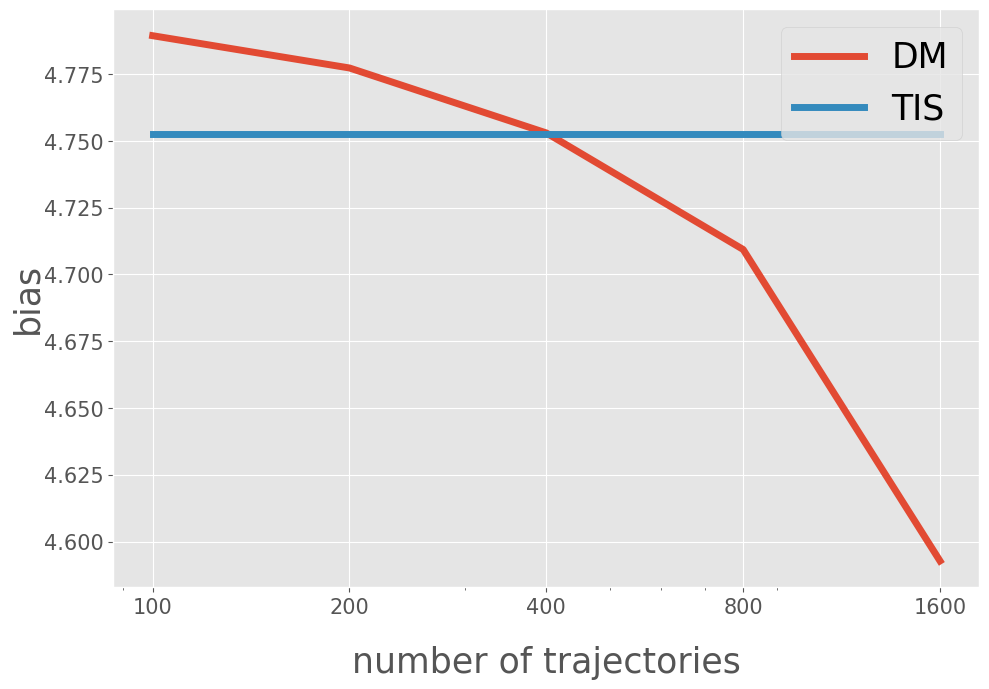

In [24]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 200, 400, 800, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'tis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_57753/685017461.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


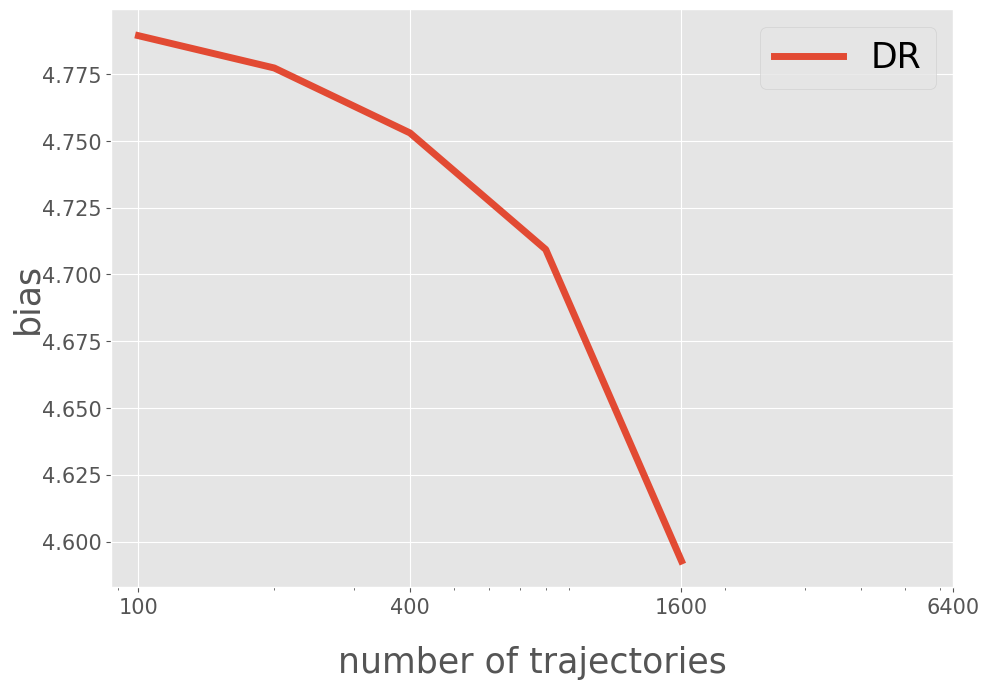

In [26]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [ ]:
variance_result_df

,index,est,variance,n_trajectories
0,dm,0,0.014763,100
1,dr,0,0.471468,100
2,drl,0,0.014601,100
3,on_policy,0,0.064765,100
4,pdis,0,0.486707,100
...,...,...,...,...
148,sm_snis,0,0.000000,25600
149,sndr,0,3.679266,25600
150,snpdis,0,0.001403,25600
151,sntis,0,0.094222,25600


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_57753/3711746799.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


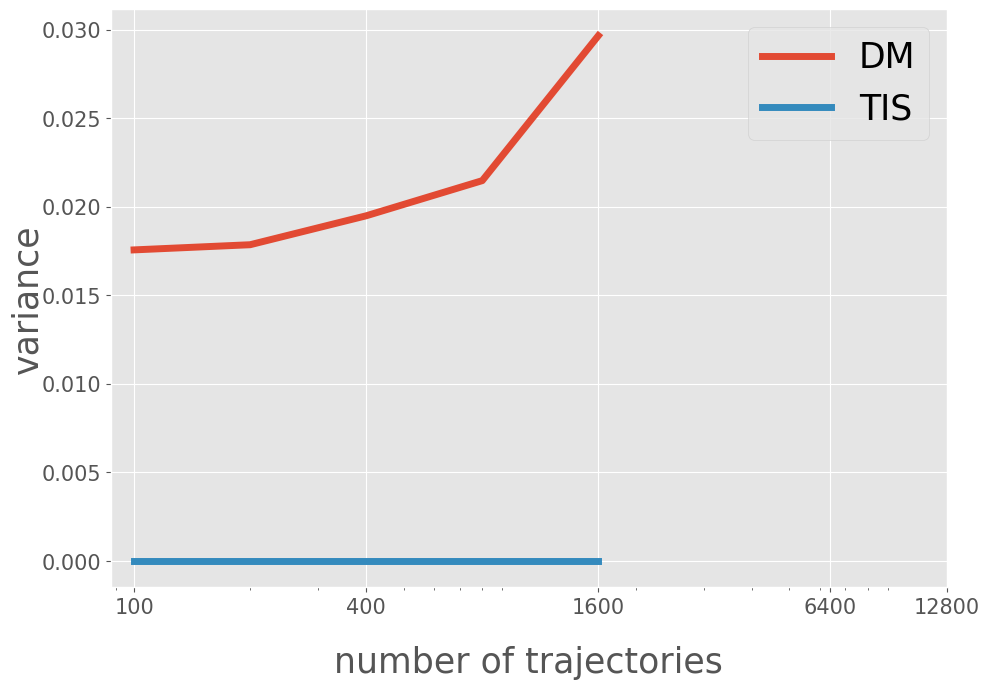

In [27]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400, 12800]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'dm' or index == 'tis') and n_trajectories <= 12800"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_70704/2997964467.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


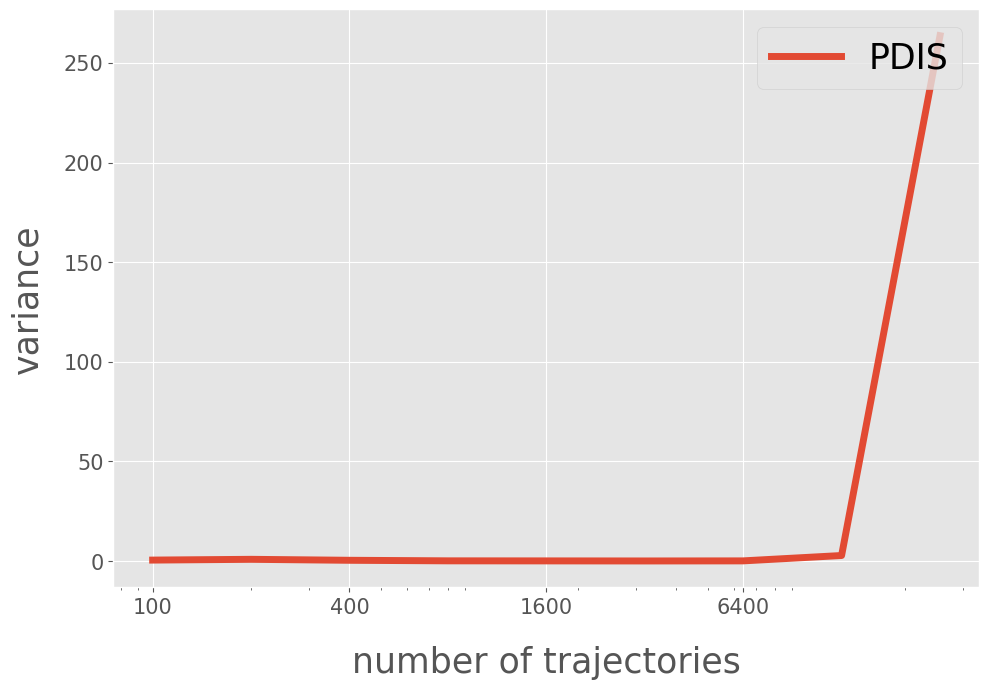

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'pdis' or index == 'tis')"),
    ci=None,
)
# title and legend
ax.legend(["PDIS", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_57753/79488338.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


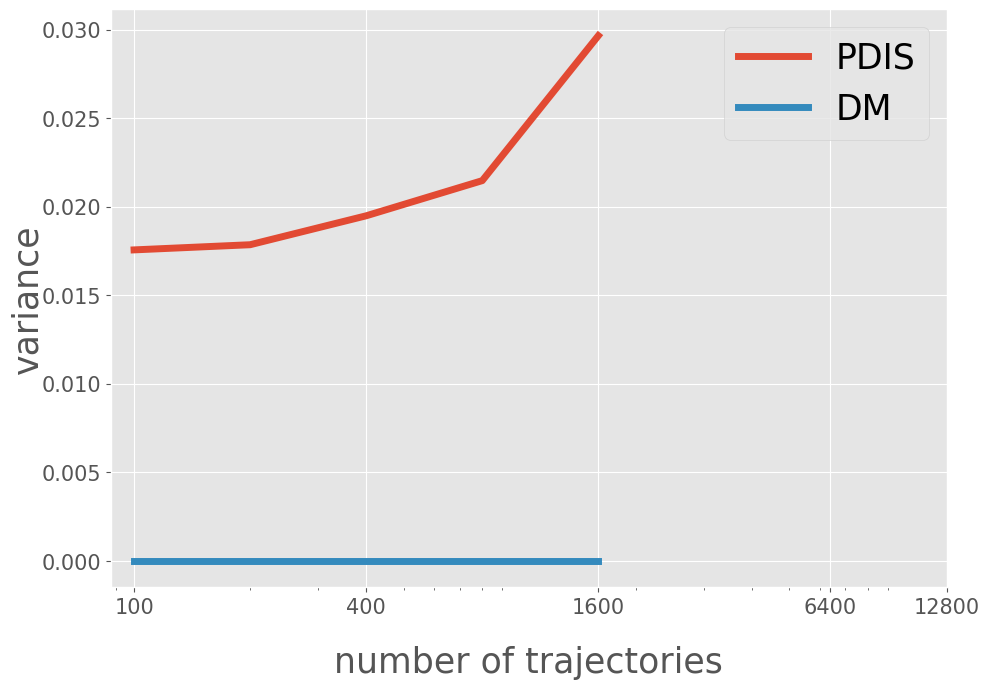

In [28]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400, 12800]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'pdis' or index == 'dm')  and n_trajectories <= 12800"),
    ci=None,
)
# title and legend
ax.legend(["PDIS", "DM"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400, 12800]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'pdis' or index == 'dm')  and n_trajectories <= 12800"),
    ci=None,
)
# title and legend
ax.legend(["PDIS", "DM"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [48]:
mse_result_df

,index,est,mse,n_trajectories
0,dm,0,22.956079,100
1,dr,0,22.956079,100
2,drl,0,22.952576,100
3,on_policy,0,0.001128,100
4,pdis,0,22.585784,100
5,sndr,0,22.956078,100
6,snpdis,0,22.585783,100
7,sntis,0,22.585784,100
8,tis,0,22.585784,100
9,dm,0,22.840697,200


In [45]:
mse_result_df[mse_result_df['index'] == 'dr']

,index,est,mse,n_trajectories
1,dr,0,22.956079,100
10,dr,0,22.840697,200
19,dr,0,22.610517,400
28,dr,0,22.199541,800
37,dr,0,21.122734,1600


In [47]:
mse_result_df[mse_result_df['index'] == '']

,index,est,mse,n_trajectories
0,dm,0,22.956079,100
9,dm,0,22.840697,200
18,dm,0,22.610517,400
27,dm,0,22.199541,800
36,dm,0,21.122734,1600


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_57753/3373674495.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


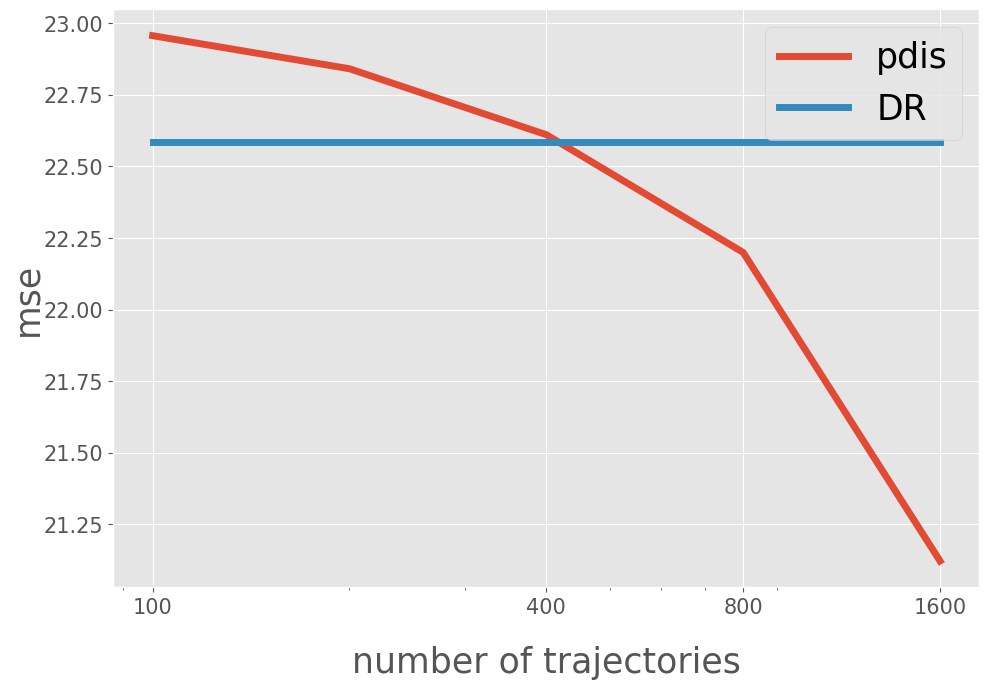

In [38]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 800, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="mse",
    hue="index",
    ax=ax,
    data=mse_result_df.query("(index == 'pdis' or index == 'dm')"),
    # data=variance_result_df.query("(index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["pdis", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("mse", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)